In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
import torch
from torchvision import transforms
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights 
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [2]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 

In [3]:
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

In [4]:
def get_input_tensors(img):
    transf = get_input_transform()
    return transf(img).unsqueeze(0)

In [5]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

In [6]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('./class.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}   

In [7]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    


In [8]:
def batch_predict(images):
    model.eval()
    preprocess_transform = get_preprocess_transform()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [20]:
def plot_and_save(image, save_path, image_path, mask):
    plt.imshow(image)
    os.makedirs(f'{save_path}/images', exist_ok=True)
    result_path = f'{save_path}/images/{os.path.basename(image_path)}'
    print(result_path)
    plt.imsave(result_path, image)
    os.makedirs(f'{save_path}/masks', exist_ok=True)
    torch.save(mask, f'{save_path}/masks/{os.path.basename(image_path)}.pth')


In [22]:
def lime(image_path, model):
    img = get_image(image_path)
    plt.imshow(img)
    
    img_t = get_input_tensors(img)
    model.eval()
    logits = model(img_t)

    probs = F.softmax(logits, dim=1)
    probs5 = probs.topk(5)
    tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

    pill_transf = get_pil_transform()

    test_pred = batch_predict([pill_transf(img)])
    test_pred.squeeze().argmax()

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                            batch_predict, # classification function
                                            top_labels=5, 
                                            hide_color=0, 
                                            num_samples=1000)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
    img_boundry1 = mark_boundaries(temp/255.0, mask)
    plot_and_save(img_boundry1, 'results/boundary_1', image_path, mask)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    img_boundry2 = mark_boundaries(temp/255.0, mask)
    plot_and_save(img_boundry2, 'results/boundary_2', image_path,mask)


images/n01608432_kite.JPEG


  0%|          | 0/1000 [00:00<?, ?it/s]

results/boundary_1/images/n01608432_kite.JPEG
results/boundary_2/images/n01608432_kite.JPEG
images/n07747607_orange.JPEG


  0%|          | 0/1000 [00:00<?, ?it/s]

results/boundary_1/images/n07747607_orange.JPEG
results/boundary_2/images/n07747607_orange.JPEG
images/n01616318_vulture.JPEG


  0%|          | 0/1000 [00:00<?, ?it/s]

results/boundary_1/images/n01616318_vulture.JPEG
results/boundary_2/images/n01616318_vulture.JPEG
images/n02098286_West_Highland_white_terrier.JPEG


  0%|          | 0/1000 [00:00<?, ?it/s]

results/boundary_1/images/n02098286_West_Highland_white_terrier.JPEG
results/boundary_2/images/n02098286_West_Highland_white_terrier.JPEG
images/n01491361_tiger_shark.JPEG


  0%|          | 0/1000 [00:00<?, ?it/s]

results/boundary_1/images/n01491361_tiger_shark.JPEG
results/boundary_2/images/n01491361_tiger_shark.JPEG
images/n02018207_American_coot.JPEG


  0%|          | 0/1000 [00:00<?, ?it/s]

results/boundary_1/images/n02018207_American_coot.JPEG
results/boundary_2/images/n02018207_American_coot.JPEG
images/n02007558_flamingo.JPEG


  0%|          | 0/1000 [00:00<?, ?it/s]

results/boundary_1/images/n02007558_flamingo.JPEG
results/boundary_2/images/n02007558_flamingo.JPEG
images/n01677366_common_iguana.JPEG


  0%|          | 0/1000 [00:00<?, ?it/s]

results/boundary_1/images/n01677366_common_iguana.JPEG
results/boundary_2/images/n01677366_common_iguana.JPEG
images/n01443537_goldfish.JPEG


  0%|          | 0/1000 [00:00<?, ?it/s]

results/boundary_1/images/n01443537_goldfish.JPEG
results/boundary_2/images/n01443537_goldfish.JPEG
images/n04037443_racer.JPEG


  0%|          | 0/1000 [00:00<?, ?it/s]

results/boundary_1/images/n04037443_racer.JPEG
results/boundary_2/images/n04037443_racer.JPEG


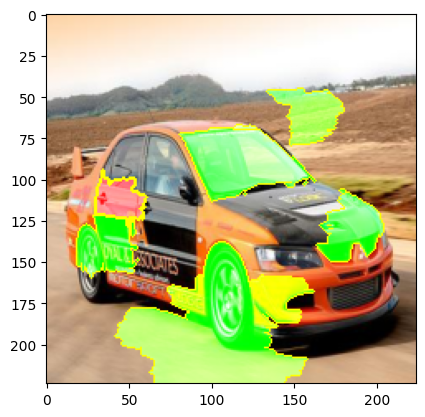

In [23]:
for image_filename in os.listdir("./images"):
    if image_filename.endswith(('.png', '.jpg', '.jpeg','JPEG')):
        image_path = os.path.join("images/",image_filename)
        print(image_path)
        lime(image_path, model)
